In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib widget

First, define plotting helper functions.

In [2]:
def plot_time(x, Fs):
    Ts = 1/Fs
    t = t = 0 + np.arange(0, x.size) * Ts
    
    fig = plt.figure(clear=True)
    plt.plot(t, x)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()

def plot_fft(x, Fs, Fs_units='', n=None):
    if n is None:
        n = len(x)
    else:
        n = int(n)

    if Fs_units == '':
        Fs_scale = 1
    elif Fs_units == 'k':
        Fs_scale = 1/1e3
    elif Fs_units == 'M':
        Fs_scale = 1/1e6
    else:
        raise(ValueError("Unsupported Fs Unit"))

    X = np.fft.fft(x[0:n])
    f = np.fft.fftfreq(X.size, d=1/Fs)

    fig = plt.figure(clear=True)
    plt.plot(np.fft.fftshift(f*Fs_scale), 20*np.log10(np.abs(np.fft.fftshift(X))))
    plt.xlabel(f'Frequency ({Fs_units}Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid()

def plot_psd(x, Fs, Fs_units=''):
    if Fs_units == '':
        Fs_scale = 1
    elif Fs_units == 'k':
        Fs_scale = 1/1e3
    elif Fs_units == 'M':
        Fs_scale = 1/1e6
    else:
        raise(ValueError("Unsupported Fs Unit"))

    f, Pxx = sig.welch(x, fs=Fs, return_onesided=False)

    fig = plt.figure(clear=True)
    plt.semilogy(f*Fs_scale, Pxx)
    plt.grid()    

def plot_filter(b, a, Fs, Fs_units=''):
    w, h = sig.freqz(b, a, fs=Fs)
    
    if Fs_units == '':
        Fs_scale = 1
    elif Fs_units == 'k':
        Fs_scale = 1/1e3
    elif Fs_units == 'M':
        Fs_scale = 1/1e6
    else:
        raise(ValueError("Unsupported Fs Unit"))

    fig = plt.figure(clear=True)
    plt.plot(w*Fs_scale, 20*np.log10(np.abs(h)))
    plt.xlabel(f'Frequency ({Fs_units}Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Filter Magnitude Response')
    plt.grid()

Load the test IQ file as a numpy array.  The IQ file contains samples from the Baltimore-area FM radio station WTMD, which is centered at 89.7 MHz.

In [3]:
Fs = 1.92e6 # Hz
filename = "/home/hicksze1/antsdr-pynq/boards/e200/fm_radio/sim/iq_files/fm_1920kHz.fc32"
IQ_interleaved = np.fromfile(filename, dtype=np.float32)
IQ = IQ_interleaved[::2] + 1j*IQ_interleaved[1::2]

Plot the input spectrum.  The plot shows the radio station centered at the radio's tuned frequency, which is shown at 0 Hz.

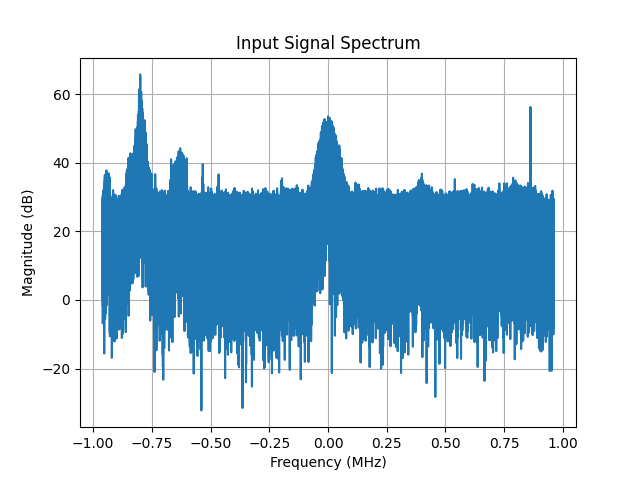

In [4]:
plot_fft(IQ, Fs, Fs_units='M', n=500e3)
plt.title("Input Signal Spectrum");

The first stage of the reception process is to use decimating low-pass filters to reduce the sample rate of the signal.  This first stage decimates the signal by a factor of 5, and the second stage decimates by 4.  The decimation filters are designed using the Parks-McClellan algorithm.

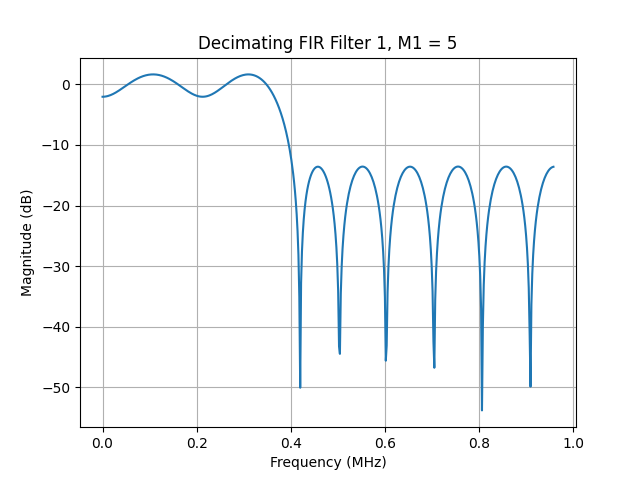

In [5]:
M1 = 5 # decimation factor
Fs_1 = Fs / M1 # output sample rate

N1 = 21 # filter order
delta_w = 1 / 100 # transition width
wp = (1/M1) - delta_w # passband freq
ws = (1/M1) + delta_w # stopband freq

h_decim_1 = sig.remez(N1, [0, wp, ws, 0.5], [1, 0], fs=1)
H_decim_1 = sig.dlti(h_decim_1, [1], dt = 1/Fs)

plot_filter(h_decim_1, [1], Fs, Fs_units='M')
plt.title("Decimating FIR Filter 1, M1 = 5");

The input signal is filtered and decimated.

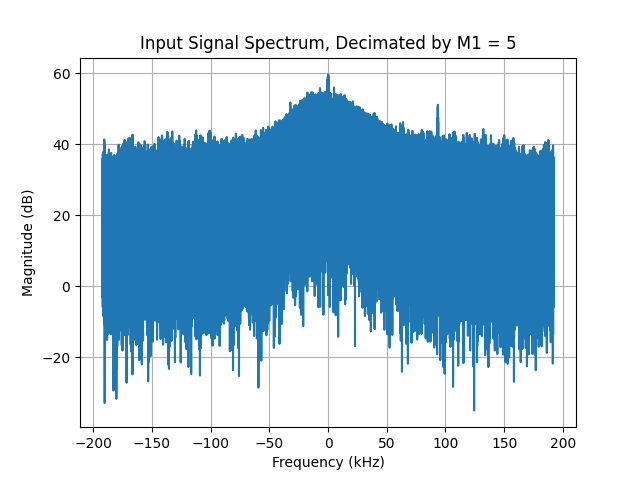

In [6]:
IQ_decim = sig.decimate(IQ, M1, ftype=H_decim_1, zero_phase=False)
plot_fft(IQ_decim, Fs_1, Fs_units='k')
plt.title("Input Signal Spectrum, Decimated by M1 = 5");

Next, the signal is FM-demodulated and the resulting spectrum is plotted.

In [7]:
def fm_demod(x):
    h_diff = [1, 0, -1]
    x_diff = sig.lfilter(h_diff, 1, x)
    demod = np.real(x) * np.imag(x_diff) - np.imag(x) * np.real(x_diff)
    return demod

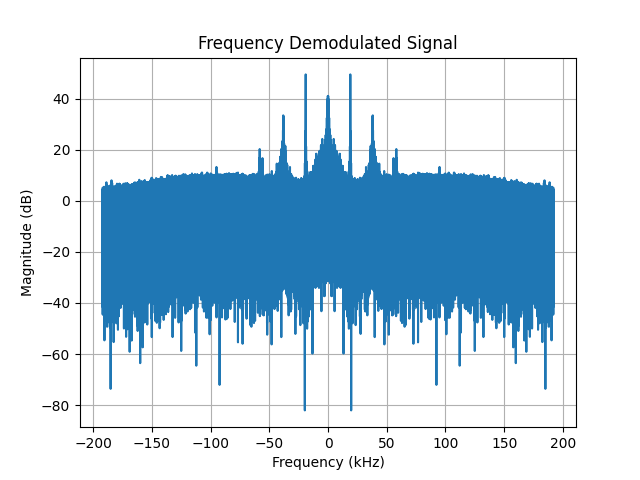

In [8]:
freq = fm_demod(IQ_decim)
plot_fft(freq, Fs_1, Fs_units='k')
plt.title("Frequency Demodulated Signal");

Two final decimation stages are used to reduce the sample rate to the rate required by the audio card.

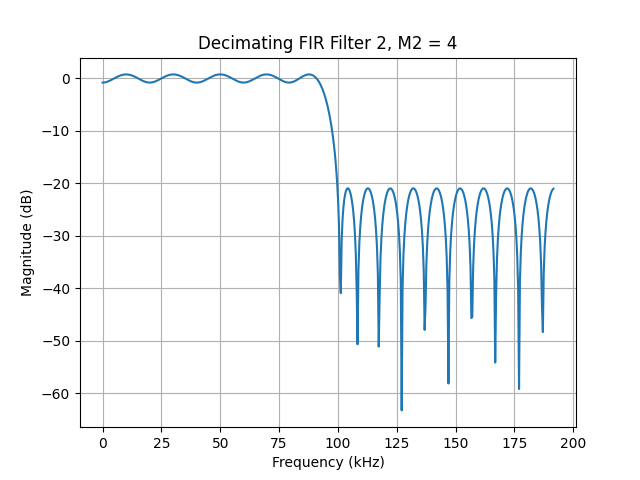

In [9]:
M2 = 4 # decimation factor
Fs_2 = Fs_1 / M2 # output sample rate

N2 = 41 # filter order
delta_w = 1 / 100 # transition width
wp = (1/M2) - delta_w # passband freq
ws = (1/M2) + delta_w # stopband freq

h_decim_2 = sig.remez(N2, [0, wp, ws, 0.5], [1, 0], fs=1)
H_decim_2 = sig.dlti(h_decim_2, [1], dt = 1/Fs_1)

plot_filter(h_decim_2, [1], Fs_1, Fs_units='k')
plt.title("Decimating FIR Filter 2, M2 = 4");

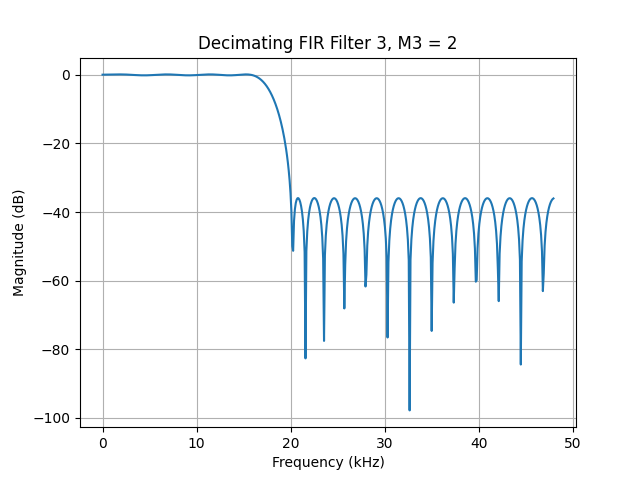

In [10]:
M3 = 2 # decimation factor
Fs_3 = Fs_2 / M3 # output sample rate

N3 = 41 # filter order

h_decim_3 = sig.remez(N3, [0, 16e3, 20e3, Fs_2/2], [1, 0], fs=Fs_2)
H_decim_3 = sig.dlti(h_decim_3, [1], dt = 1/Fs_2)

plot_filter(h_decim_3, [1], Fs_2, Fs_units='k')
plt.title("Decimating FIR Filter 3, M3 = 2");

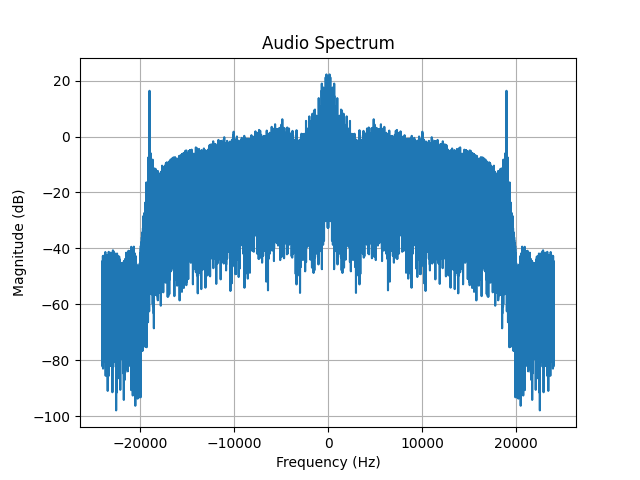

In [11]:
freq_decim = sig.decimate(freq, M2, ftype=H_decim_2, zero_phase=False)
audio = sig.decimate(freq_decim, M3, ftype=H_decim_3, zero_phase=False)
plot_fft(audio, Fs_3)
plt.title("Audio Spectrum");

Finally, an FM deemphasis filter is applied to correct the audio spectrum.  Broadcast FM radio signals are pre-distorted by the transmitting station, so the distortion must be reversed at the receiver.

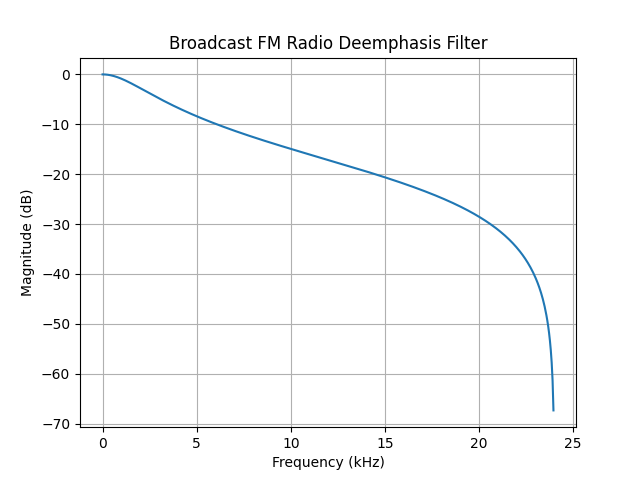

In [12]:
tau = 75e-6

wc = 1 / tau
wca = 2 * Fs_3 * np.tan(wc / (2*Fs_3))
k = -wca / (2*Fs_3)
z1 = -1
p1 = (1 + k) / (1 - k)
b0 = -k / (1 - k)
b = [b0, b0*-z1]
a = [1, -p1]

plot_filter(b, a, Fs=Fs_3, Fs_units='k')
plt.title("Broadcast FM Radio Deemphasis Filter");

In [13]:
deemph = sig.lfilter(b, a, audio)

Finally, the demodulated audio can be played.

In [14]:
from IPython.display import Audio

Audio(deemph, rate=Fs_3)

The FM demodulation process is combined into a single function below.

In [15]:
def broadcast_fm_rx(IQ, debug=False):
    IQ_decim = sig.decimate(IQ, M1, ftype=H_decim_1, zero_phase=False)
    freq = fm_demod(IQ_decim)
    freq_decim = sig.decimate(freq, M2, ftype=H_decim_2, zero_phase=False)
    audio = sig.decimate(freq_decim, M3, ftype=H_decim_3, zero_phase=False)
    deemph = sig.lfilter(b, a, audio)
    if debug:
        plot_time(np.real(IQ_decim_1), Fs_1)
        plot_time(np.real(IQ_decim_2), Fs_2)
        plot_time(freq, Fs_2)
        plot_time(audio, Fs_3)
    return deemph

In [16]:
Fs = 1.92e6 # Hz
filename = "/home/hicksze1/antsdr-pynq/boards/e200/fm_radio/sim/iq_files/fm_1920kHz.fc32"
IQ_interleaved = np.fromfile(filename, dtype=np.float32)
IQ = IQ_interleaved[::2] + 1j*IQ_interleaved[1::2]

audio = broadcast_fm_rx(IQ)
Audio(audio, rate=48000)

In [19]:
Fs = 1.92e6 # Hz
filename = "/home/hicksze1/antsdr-pynq/boards/e200/fm_radio/sim/iq_files/tb_chirp.ic16"
IQ_interleaved = np.fromfile(filename, dtype=np.int16)
IQ = IQ_interleaved[::2] + 1j*IQ_interleaved[1::2]

# plot_time(np.real(IQ), Fs)
# plt.title("Chirp Waveform")

linear_chirp = broadcast_fm_rx(IQ)
Audio(linear_chirp, rate=48000)
# plot_time(linear_chirp, 48000)
# plt.title("Demodulated Chirp Waveform")